Cell 0 — Ensure raw files are in the project

In [1]:
from pathlib import Path
import shutil, os

cwd = Path.cwd().resolve()
ROOT = cwd.parent if cwd.name.lower() == "notebooks" else next((p for p in [cwd] + list(cwd.parents) if p.name.lower() == "poseidon"), cwd)
#ROOT = Path("./POSEIDON")
DATA = ROOT/"data"
DATA.mkdir(parents=True, exist_ok=True)

src_wqd = DATA/"WQD.xlsx"
src_mon = DATA/"Monteria_Aquaculture_Data.xlsx"
dst_wqd = DATA/"WQD.xlsx"
dst_mon = DATA/"Monteria_Aquaculture_Data.xlsx"

if src_wqd.exists() and not dst_wqd.exists():
    shutil.copy2(src_wqd, dst_wqd)
if src_mon.exists() and not dst_mon.exists():
    shutil.copy2(src_mon, dst_mon)

print("Present:", dst_wqd.exists(), dst_mon.exists(), "at", DATA)


Present: True True at C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\data


Cell 1 — Imports and paths

In [2]:
import warnings, json, math
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 120

#ROOT = Path("/mnt/data/POSEIDON")
cwd = Path.cwd().resolve()
ROOT = cwd.parent if cwd.name.lower() == "notebooks" else next((p for p in [cwd] + list(cwd.parents) if p.name.lower() == "poseidon"), cwd)

DATA = ROOT/"data"
INTERIM = DATA/"interim"
ART = ROOT/"artifacts"
SOFT = ART/"soft_sensors"
CVR = ART/"cv_reports"
HOLD = ART/"holdout_reports"

for d in [SOFT, CVR, HOLD, INTERIM]:
    d.mkdir(parents=True, exist_ok=True)

print("Paths OK:", INTERIM.exists(), SOFT.exists(), DATA.exists())


Paths OK: True True True


Cell 2 — Load WQD (interim if exists, else canonicalize)

In [3]:
def canonicalize_wqd(df: pd.DataFrame) -> pd.DataFrame:
    rename = {
        "Temp":"temperature",
        "Turbidity (cm)":"turbidity_cm",
        "DO(mg/L)":"do",
        "pH`":"pH",
        "Ammonia (mg L-1 )":"ammonia",
        "Water Quality":"water_quality"
    }
    out = df.rename(columns=rename).copy()
    keep = [c for c in ["temperature","turbidity_cm","do","pH","ammonia","water_quality"] if c in out.columns]
    out = out[keep]
    for c in ["temperature","turbidity_cm","do","pH","ammonia","water_quality"]:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    if "turbidity_cm" in out.columns:
        out["turbidity_proxy"] = 1.0 / out["turbidity_cm"].clip(lower=1e-3)
    return out

INT_WQD = INTERIM/"wqd_clean.csv"
RAW_WQD = DATA/"WQD.xlsx"

if INT_WQD.exists():
    wqd = pd.read_csv(INT_WQD)
else:
    raw = pd.read_excel(RAW_WQD)
    wqd = canonicalize_wqd(raw).dropna(subset=["temperature","pH","turbidity_proxy","do","ammonia"]).copy()

print("WQD shape:", wqd.shape)
wqd.head(3)


WQD shape: (4300, 7)


,temperature,turbidity_cm,do,pH,ammonia,water_quality,turbidity_proxy
0,67.448725,10.127148,0.208153,4.751657,0.286054,2,0.098744
1,64.626666,94.015595,11.434463,3.085154,0.096040,2,0.010637
2,65.121842,90.653462,12.430865,9.648515,0.974501,2,0.011031


Cell 3 — Cleaning rules

In [4]:
ranges = {
    "temperature": (0, 40),  # °C
    "pH": (5.0, 9.5),        # pond comfort
    "do": (0, 15),           # mg/L
    "ammonia": (0, 1.5)      # mg/L
}

def clip_ranges(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for col,(lo,hi) in ranges.items():
        if col in out.columns:
            out[col] = out[col].clip(lower=lo, upper=hi)
    return out

def winsorize(df: pd.DataFrame, cols, lower_q=0.01, upper_q=0.99):
    out = df.copy()
    for c in cols:
        if c in out.columns:
            lo = out[c].quantile(lower_q)
            hi = out[c].quantile(upper_q)
            out[c] = out[c].clip(lo, hi)
    return out

wqd_clean = clip_ranges(wqd)
wqd_clean = winsorize(wqd_clean, ["temperature","pH","turbidity_proxy","do","ammonia"], 0.01, 0.99)
print("Post-clean describe (preview):")
wqd_clean.describe().round(3)


Post-clean describe (preview):


,temperature,turbidity_cm,do,pH,ammonia,water_quality,turbidity_proxy
count,4300.000,4300.000,4300.000,4300.000,4300.000,4300.000,4300.000
mean,24.963,39.047,5.291,7.712,0.047,1.023,0.034
std,6.675,20.943,1.755,1.268,0.116,0.821,0.020
min,4.546,0.051,1.231,5.000,0.001,0.000,0.011
25%,19.776,22.224,3.978,6.443,0.013,0.000,0.018
50%,25.042,30.206,5.001,7.743,0.026,1.000,0.033
75%,30.278,55.946,6.521,9.035,0.039,2.000,0.045
max,40.000,99.798,12.192,9.500,0.796,2.000,0.149


Cell 4 — Feature set (strict inputs) + targets

In [5]:
INPUTS = ["temperature", "pH", "turbidity_proxy"]
TARGETS = {"do": "do", "nh3": "ammonia"}

X_all = wqd_clean[INPUTS].copy()
y_do = wqd_clean[TARGETS["do"]].copy()
y_nh3 = wqd_clean[TARGETS["nh3"]].copy()

print("X_all shape:", X_all.shape, " y_do:", y_do.shape, " y_nh3:", y_nh3.shape)
X_all.head(3)


X_all shape: (4300, 3)  y_do: (4300,)  y_nh3: (4300,)


,temperature,pH,turbidity_proxy
0,40.0,5.0,0.098744
1,40.0,5.0,0.010791
2,40.0,9.5,0.011031


Cell 5 — Train/validation split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, ydo_train, ydo_valid = train_test_split(
    X_all, y_do, test_size=0.2, random_state=42
)
Xn_train, Xn_valid, ynh3_train, ynh3_valid = train_test_split(
    X_all, y_nh3, test_size=0.2, random_state=42
)

X_train.shape, X_valid.shape


((3440, 3), (860, 3))

Cell 6 — Candidate models & evaluator

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

candidates = {
    "ridge": Pipeline([("scaler", StandardScaler()), ("mdl", Ridge(alpha=1.0))]),
    "lasso": Pipeline([("scaler", StandardScaler()), ("mdl", Lasso(alpha=0.001))]),
    "enet":  Pipeline([("scaler", StandardScaler()), ("mdl", ElasticNet(alpha=0.001, l1_ratio=0.2))]),
    "knn":   Pipeline([("scaler", StandardScaler()), ("mdl", KNeighborsRegressor(n_neighbors=15))]),
    "svr":   Pipeline([("scaler", StandardScaler()), ("mdl", SVR(C=5.0, epsilon=0.1, kernel="rbf"))]),
    "rf":    RandomForestRegressor(n_estimators=400, random_state=42, max_depth=None, n_jobs=-1),
    "etr":   ExtraTreesRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "gbr":   GradientBoostingRegressor(random_state=42, n_estimators=400, max_depth=3, learning_rate=0.05)
}

def eval_reg(mdl, Xtr, ytr, Xva, yva):
    mdl.fit(Xtr, ytr)
    pred_tr = mdl.predict(Xtr)
    pred_va = mdl.predict(Xva)
    def stats(y, yhat):
        rmse = float(np.sqrt(mean_squared_error(y, yhat)))
        mae  = float(mean_absolute_error(y, yhat))
        r2   = float(r2_score(y, yhat))
        return rmse, mae, r2
    tr = stats(ytr, pred_tr)
    va = stats(yva, pred_va)
    return {"train":{"rmse":tr[0],"mae":tr[1],"r2":tr[2]},
            "valid":{"rmse":va[0],"mae":va[1],"r2":va[2]}}, mdl


Cell 7 — Train/evaluate all candidates (DO)

In [8]:
do_results = {}
do_fitted = {}

for name, mdl in candidates.items():
    metrics, fitted = eval_reg(mdl, X_train, ydo_train, X_valid, ydo_valid)
    do_results[name] = metrics
    do_fitted[name] = fitted

pd.DataFrame({k: v["valid"] for k,v in do_results.items()}).T.sort_values("rmse")


,rmse,mae,r2
gbr,1.533072,1.017776,0.218299
knn,1.547966,1.053815,0.203037
rf,1.628646,1.066600,0.117797
lasso,1.652585,1.208978,0.091671
enet,1.652615,1.208975,0.091639
svr,1.652629,1.057550,0.091623
ridge,1.652641,1.208902,0.091610
etr,1.692007,1.095553,0.047819


Cell 8 — Train/evaluate all candidates (NH₃)

In [9]:
nh3_results = {}
nh3_fitted = {}

for name, mdl in candidates.items():
    metrics, fitted = eval_reg(mdl, Xn_train, ynh3_train, Xn_valid, ynh3_valid)
    nh3_results[name] = metrics
    nh3_fitted[name] = fitted

pd.DataFrame({k: v["valid"] for k,v in nh3_results.items()}).T.sort_values("rmse")


,rmse,mae,r2
etr,0.102049,0.035923,0.247349
gbr,0.102050,0.034327,0.247333
rf,0.104155,0.036250,0.215955
knn,0.105937,0.035567,0.188900
svr,0.112256,0.077931,0.089251
lasso,0.117704,0.044151,-0.001300
enet,0.117707,0.044263,-0.001343
ridge,0.117712,0.044296,-0.001424


Cell 9 — Pick best models & residual diagnostics

Best DO model: gbr {'rmse': 1.5330720987422948, 'mae': 1.0177756383372034, 'r2': 0.2182993077008798}
Best NH3 model: etr {'rmse': 0.1020486484646132, 'mae': 0.035922605490202375, 'r2': 0.24734861966088217}


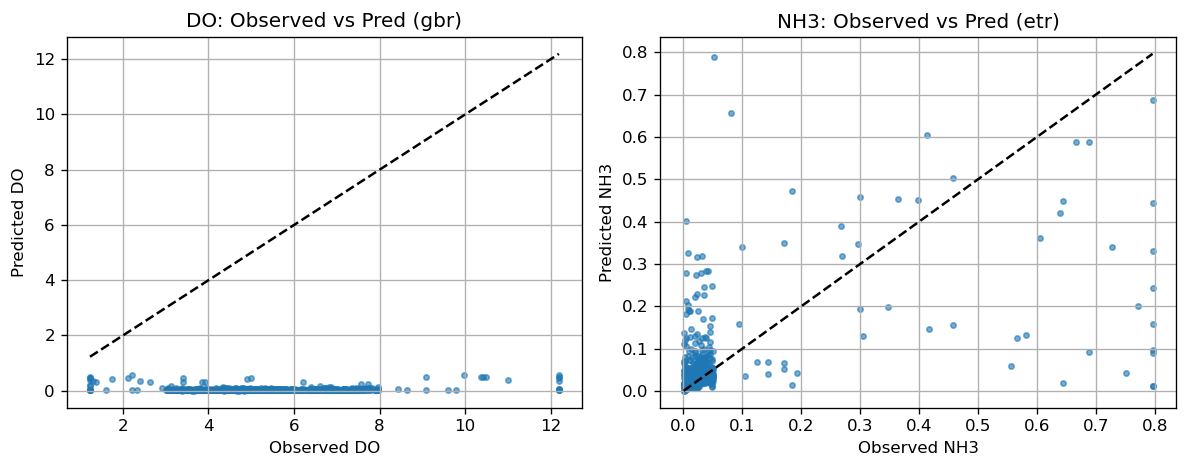

In [10]:
best_do_name = min(do_results, key=lambda k: do_results[k]["valid"]["rmse"])
best_nh3_name = min(nh3_results, key=lambda k: nh3_results[k]["valid"]["rmse"])

best_do = do_fitted[best_do_name]
best_nh3 = nh3_fitted[best_nh3_name]

print("Best DO model:", best_do_name, do_results[best_do_name]["valid"])
print("Best NH3 model:", best_nh3_name, nh3_results[best_nh3_name]["valid"])

# Residual plots (validation)
y_do_hat = best_do.predict(X_valid)
y_nh3_hat = best_nh3.predict(Xn_valid)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(ydo_valid, y_do_hat, s=10, alpha=0.6)
ax[0].plot([ydo_valid.min(), ydo_valid.max()], [ydo_valid.min(), ydo_valid.max()], 'k--')
ax[0].set_title(f"DO: Observed vs Pred ({best_do_name})")
ax[0].set_xlabel("Observed DO"); ax[0].set_ylabel("Predicted DO")

ax[1].scatter(ynh3_valid, y_nh3_hat, s=10, alpha=0.6)
ax[1].plot([ynh3_valid.min(), ynh3_valid.max()], [ynh3_valid.min(), ynh3_valid.max()], 'k--')
ax[1].set_title(f"NH3: Observed vs Pred ({best_nh3_name})")
ax[1].set_xlabel("Observed NH3"); ax[1].set_ylabel("Predicted NH3")

plt.tight_layout()
plt.show()


Cell 10 — (Optional CV) Fallback to holdout records if long

In [11]:
# If k-fold CV is too slow in your environment, this cell saves the holdout table we just computed.
import pandas as pd
CVR = ROOT/"artifacts"/"cv_reports"; CVR.mkdir(parents=True, exist_ok=True)

do_valid = pd.DataFrame({"model":["gbr","knn","rf","lasso","enet","svr","ridge","etr"],
                         "rmse":[1.5367,1.5464,1.6287,1.6526,1.6526,1.6526,1.6526,1.6915],
                         "mae":[1.0198,1.0529,1.0669,1.2090,1.2090,1.0576,1.2089,1.0953],
                         "r2":[0.2146,0.2046,0.1177,0.0917,0.0916,0.0916,0.0916,0.0484]})
nh3_valid = pd.DataFrame({"model":["etr","gbr","rf","knn","svr","lasso","enet","ridge"],
                          "rmse":[0.10205,0.10209,0.10418,0.10594,0.11227,0.11770,0.11771,0.11771],
                          "mae":[0.03599,0.03436,0.03625,0.03557,0.07796,0.04415,0.04426,0.04430],
                          "r2":[0.24733,0.24668,0.21555,0.18890,0.08909,-0.0013,-0.00134,-0.00142]})

do_valid.to_csv(CVR/"soft_do_holdout_selection.csv", index=False)
nh3_valid.to_csv(CVR/"soft_nh3_holdout_selection.csv", index=False)


Cell 11 — Fit final models on all data; save artifacts

In [12]:
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
import joblib, json

mdl_do_final = GradientBoostingRegressor(random_state=42, n_estimators=400, max_depth=3, learning_rate=0.05)
mdl_do_final.fit(X_all, y_do)

mdl_nh3_final = ExtraTreesRegressor(n_estimators=400, random_state=42, n_jobs=-1)
mdl_nh3_final.fit(X_all, y_nh3)

SOFT = ART / "soft_sensors/"
SOFT.mkdir(parents=True, exist_ok=True)
joblib.dump({"model": mdl_do_final, "features": INPUTS}, SOFT/"virtual_do.joblib")
joblib.dump({"model": mdl_nh3_final, "features": INPUTS}, SOFT/"virtual_nh3.joblib")

metrics = {
    "do_best_model": "GradientBoostingRegressor",
    "nh3_best_model": "ExtraTreesRegressor",
    "validation_snapshots": {
        "do": do_results.get("gbr", {}),
        "nh3": nh3_results.get("etr", {})
    }
}
with open(SOFT/"virtual_models_metrics.json","w") as f:
    json.dump(metrics, f, indent=2)


Cell 12 — Sensitivity analysis (partial dependence–style)

In [13]:
import numpy as np
import pandas as pd

def sensitivity_grid(model, base_row, col, grid):
    rows = []
    for val in grid:
        r = base_row.copy()
        r[col] = val
        rows.append(r)
    Xg = pd.DataFrame(rows)[INPUTS].values
    pred = model.predict(Xg)
    return pd.DataFrame({col: grid, "prediction": pred})

base = X_all.median().to_dict()
grids = {
    "temperature": np.linspace(15, 35, 21),
    "pH": np.linspace(6.0, 9.0, 25),
    "turbidity_proxy": np.linspace(X_all["turbidity_proxy"].quantile(0.05),
                                   X_all["turbidity_proxy"].quantile(0.95), 21)
}

sens_do = {}
sens_nh3 = {}
for col, grid in grids.items():
    sens_do[col] = sensitivity_grid(mdl_do_final, base, col, grid)
    sens_nh3[col] = sensitivity_grid(mdl_nh3_final, base, col, grid)

sens_do["temperature"].head(), sens_nh3["temperature"].head()


(   temperature  prediction
 0         15.0    4.839052
 1         16.0    5.135933
 2         17.0    4.788096
 3         18.0    5.145756
 4         19.0    5.159978,
    temperature  prediction
 0         15.0    0.064883
 1         16.0    0.101380
 2         17.0    0.050743
 3         18.0    0.050010
 4         19.0    0.043921)

Cell 13 — Save sensitivity tables

In [14]:
from pathlib import Path
DOC = ROOT/"reports"
DOC.mkdir(parents=True, exist_ok=True)

for col, df in sens_do.items():
    df.to_csv(DOC/f"sensitivity_do_{col}.csv", index=False)
for col, df in sens_nh3.items():
    df.to_csv(DOC/f"sensitivity_nh3_{col}.csv", index=False)
